# Basic Generative Adversarial Network (GAN) Implementation

This notebook presents the implementation of a Generative Adversarial Network (GAN) using PyTorch to address the problem of generating synthetic data that resembles real data. The real data is a ring mixture dataset.

## Main imports

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import math
from IPython.display import display, clear_output
import importlib

# Reload to capture any external file changes
import dataset
import models
import train
import evaluation
import visualization
importlib.reload(dataset)
importlib.reload(models)
importlib.reload(train)
importlib.reload(evaluation)
importlib.reload(visualization)

from dataset import RingMixtureDataset
from models import Generator, Discriminator
from evaluation import sliced_wasserstein_distance, mode_stats, compute_mode_centers, compute_metrics
from train import train_one_epoch
from visualization import Visualizer


## Training paramenters configurarion

- z_dim: dimension of the Generator input noise vector z (here 2D, convenient for visualization in toy 2D GANs).
- discriminator_training_steps: how many Discriminator updates we perform per Generator update (here 1:1).
- training_epochs: number of full passes through the dataset.

**RingMixtureDataset** is a custom dataset that produces a toy 2D distribution (a mixture arranged on a ring).
- batch_size: number of real samples processed per training step.
- dataset_size: how many samples to generate in the synthetic dataset.
- samples_to_visualize: how many points we will plot when visualizing the learned distribution.

**Neural Networs**
- hidden_layer_size: width of the hidden layers for both networks (small here because this is a simple toy problem).
- G = Generator(...).to(device) creates the Generator and moves it to the selected device (cpu or cuda).
- D = Discriminator(...).to(device) creates the Discriminator and moves it to the same device.

**Loss**
- nn.BCEWithLogitsLoss() implements binary cross-entropy where the input is a logit (raw score). It is commonly used in GANs where the Discriminator predicts “real” vs “fake”.

**Optimizers**: Adam is a standard choice for GAN training.
- optG = optim.Adam(G.parameters(), lr=1e-3) creates an optimizer for the Generator.
- optD = optim.Adam(D.parameters(), lr=1e-3) creates an optimizer for the Discriminator.

In [ ]:
# Configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

batch_size = 32
z_dim = 2
discriminator_training_steps = 1
dataset_size = 2000
samples_to_visualize = 2000

training_epochs = 50

# 1. Create Dataset & Loader
dataset = RingMixtureDataset(n_samples=dataset_size, seed=0, collapse_to=[])
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=0)

# 2. Initialize Models
hidden_layer_size = 16
G = Generator(z_dim=z_dim, h=hidden_layer_size).to(device)
D = Discriminator(h=hidden_layer_size).to(device)

bce = nn.BCEWithLogitsLoss()
optG = optim.Adam(G.parameters(), lr=2e-3, betas=(0.5, 0.999))
optD = optim.Adam(D.parameters(), lr=2e-3, betas=(0.5, 0.999))


Using device: cpu
16 None 0


## Training loop + live visualization

This cell sets up a **Visualizer** to display training progress inside the notebook, then runs the **epoch-based training loop**.  
At each epoch we:
1. Train the GAN for one full pass over the dataset.
2. Generate samples from the Generator for monitoring.
3. Compute quality/diversity metrics:
- SWD: distribution match (quality)
- JS divergence to uniform: mode balance (diversity)
- Coverage: how many modes the Generator learned to represent
4. Update the plots interactively.

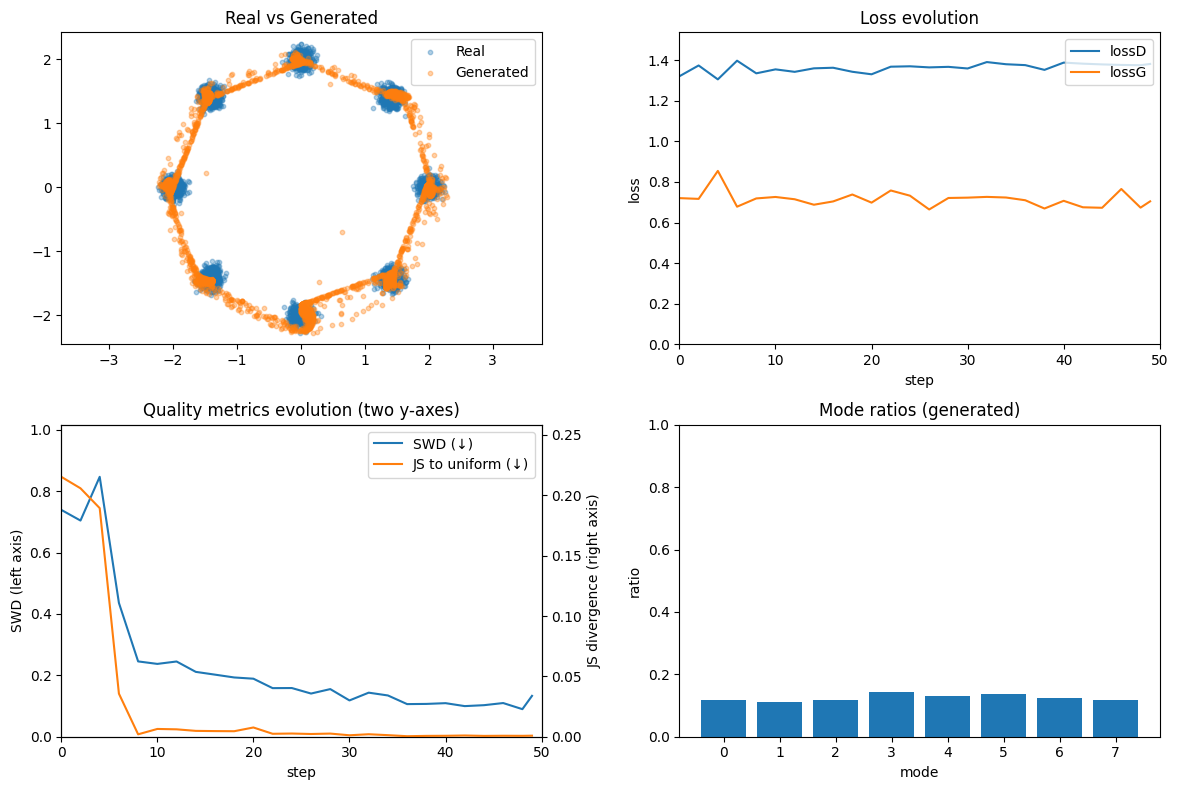

Final stats: SWD 0.1332 | JS divergence 0.0009 | Coverage: 8/8


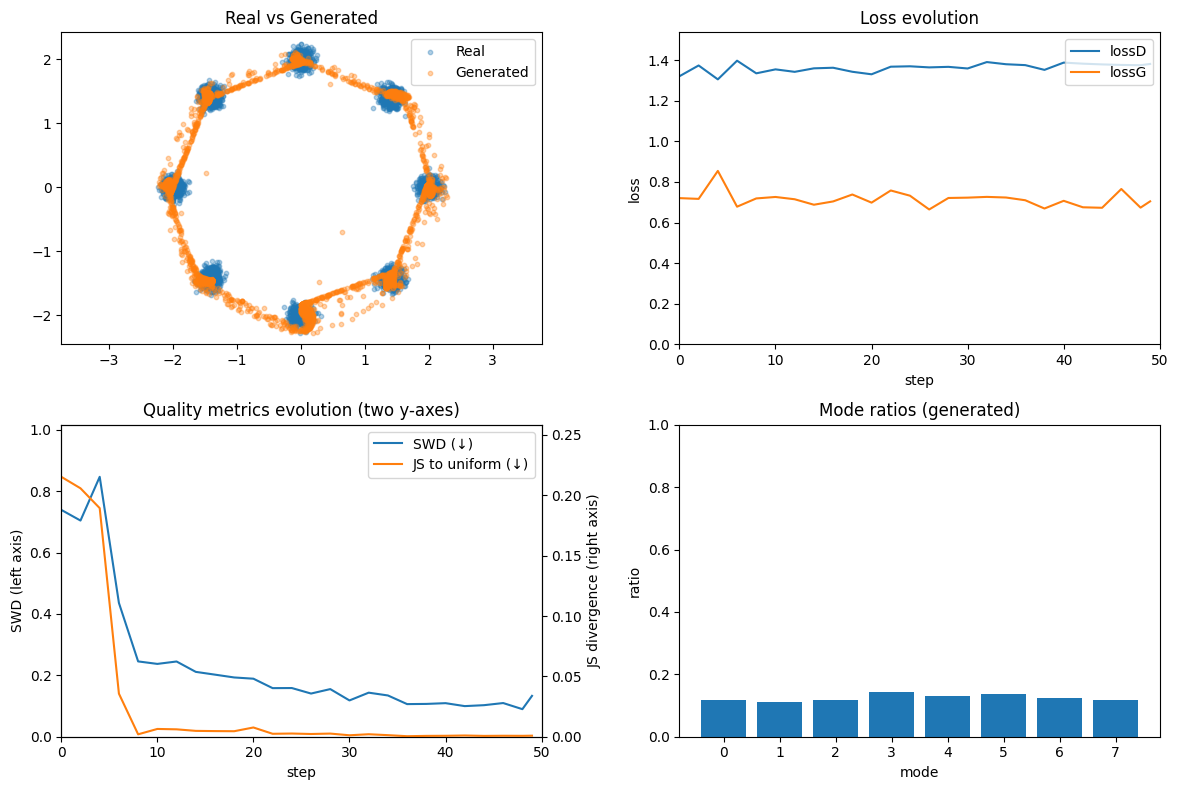

In [47]:
# nitialize Visualizer with notebook_mode=True
visualizer = Visualizer(dataset, device=device, samples_to_visualize=samples_to_visualize, notebook_mode=True, max_steps=training_epochs)

print("Setup complete. Starting training...")

for epoch in range(training_epochs):
    # Train one epoch
    lossD_item, lossG_item = train_one_epoch(G, D, optG, optD, loader, bce, discriminator_training_steps, z_dim, device)
    
    # On every epoch (or step), update visualization
    # Compute metrics for visualization
    with torch.no_grad():
        # Generate samples for visualization
        fake_vis = G(torch.randn(samples_to_visualize, z_dim, device=device)).cpu()
        
        # Compute metrics
        real_vis = dataset.x[:samples_to_visualize].to(device)
        swd = sliced_wasserstein_distance(real_vis, fake_vis.to(device), device=device)
        
        centers = compute_mode_centers(dataset.k, dataset.radius).to(device)
        stats = mode_stats(fake_vis.to(device), centers, sigma=dataset.sigma)
    
    
    
    # Print status
    if epoch % 2 == 0 or epoch == training_epochs - 1:
        #print(f"Epoch {epoch} | D: {lossD_item:.4f} | G: {lossG_item:.4f} | SWD: {swd:.4f}")
        # Update plots
        visualizer.update(epoch, lossD_item, lossG_item, fake_vis, swd, stats)

print(f"Final stats: SWD {swd:.4f} | JS divergence {stats['js_to_uniform']:.4f} | Coverage: {stats['coverage']}/{dataset.k}")
